In [1]:
# imports
import numpy as np
import pandas as pd
import os, sys, pdb, pytz
import matplotlib.pyplot as plt

# matplotlib stuff
%matplotlib inline
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

# astropy 
import astropy.units as u
from astropy.time import Time
from astropy.table import QTable
from astroquery.gaia import Gaia
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

In [2]:
# GBT information 
beamLabel = ["L","S","C","X"]
upp = [1.73, 2.60, 7.8, 11.6]
low = [1.15, 1.73, 3.95, 7.8]
beams = [12.6/x for x in upp]
beamdeg =[x/60.0 for x in beams]
beamDict = dict(zip(beamLabel, beamdeg))
freqDict = dict(zip(beamLabel, upp))

In [3]:
# set the data directory
datdir = os.path.realpath('__file__' + "/../data/") + "/"
if not os.path.isdir(datdir):
    os.mkdir(datdir)
print("Data directory: " + datdir)

Data directory: /Users/michael/Desktop/seti-fortuitous-obs/data/


In [4]:
# function to fix the arrays that were written as strings
def string_to_array(string_data):
    cleaned_data = string_data.strip('[]\n').split()
    return np.array([float(value) for value in cleaned_data])

In [5]:
# function to read csv and parse appropriate strings as arrays
def read_csv(datfile):
    # set names of columns to fix
    cols_to_fix = ['ra_trans', 'dec_trans', 'sep_trans', \
               'maxdrift_trans', 'ra_rec', 'dec_rec', \
               'sep_rec', 'maxdrift_rec']

    # read the data
    df = pd.read_csv(datfile)
    
    # turn long strings back into arrays
    for col_name in cols_to_fix:
        arr = []
        for i in range(len(df)):
            arr.append(string_to_array(df.loc[i,col_name]))
        df[col_name] = arr
        
    return df

In [6]:
# download the data if they aren't already there
datfile = datdir + "fortuitous.csv"
if not os.path.isfile(datfile):
    print("derp")

# read the file
df = read_csv(datfile)

In [7]:
# function to download gaia tbl
def get_gaia_stars(max_dist=(100.0 * u.pc)):
    # construct the query
    query = f"SELECT source_id, ra, dec, parallax, distance_gspphot, pmra, pmdec, radial_velocity \
             FROM gaiadr3.gaia_source \
             WHERE distance_gspphot <= {max_dist.value}\
             AND ruwe <1.4"

    # submit the query and get results
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [8]:
# read in gaia data, download if it's not present
gaiafile = datdir + "gaia.ecsv"
if not os.path.isfile(gaiafile):
    gaia_tbl = get_gaia_stars()
    gaia_tbl.write(gaiafile, overwrite=True)
else:
    gaia_tbl = QTable.read(gaiafile)

In [9]:
def format_dec_string(coord):
    fs = 1
    if coord < 0:
        fs = -1
        coord = abs(coord)
    qS = '"'
    return f"{int(fs*float(int(coord)))}$^\circ$ {int((coord - float(int(coord))) // (1/60))}' {np.around((coord - float(int(coord)) - ((coord - float(int(coord))) // (1/60))*(1/60))/(1/(60*60)),3)}{qS} "

def format_ra_string(coord):
    return f"{int(coord // 15)}h {int((coord - (coord // 15)*15) // 0.25)}m {np.around((coord - (coord // 15)*15 - ((coord - (coord // 15)*15) // 0.25)*0.25)/(360/(24*60*60)),3)}s"

In [10]:
# define function to plot focal lines on sky
def plot_probe_focal_lines(i):
    ra_trans = df.iloc[i].ra_trans
    dec_trans = df.iloc[i].dec_trans

    ra_rec = df.iloc[i].ra_rec
    dec_rec = df.iloc[i].dec_rec

    ra_obs = df.iloc[i].ra_obs
    dec_obs = df.iloc[i].dec_obs
    band = df.iloc[i].obs_band

    # make plot objects
    fig = plt.figure(figsize=(7,7))
    axs = fig.add_subplot(1, 1, 1)

    # plot focal lines for transmitter and receiver
    axs.plot(ra_trans, dec_trans, color="tab:blue", label="Transmitter")
    axs.plot(ra_rec, dec_rec, color="tab:orange", label="Receiver")

    # plot the size of the band
    circ = plt.Circle((ra_obs, dec_obs), beamDict[band]/2.0, color='k', fill=False)
    axs.add_patch(circ)
    
    # annotate the beam circle
    label = axs.annotate(band, xy=(ra_obs-beamDict[band]/2.6, dec_obs+beamDict[band]/2.6), fontsize=18)
    
    # inver the RA axis
    axs.invert_xaxis()

    # format the tick marks
    axs.set_xticklabels(map(format_ra_string, axs.get_xticks()), rotation=45, fontsize=10, ha="right")
    axs.set_yticklabels(map(format_dec_string, axs.get_yticks()), fontsize=10)

    # set the axis labels
    axs.set_xlabel("Right Ascension", fontsize=12)
    axs.set_ylabel("Declination", fontsize=12)

    axs.set_aspect("equal")
    axs.grid(ls="--", alpha=0.5)
    axs.legend(fontsize=12, loc="upper left")
    plt.show()

/var/folders/3c/fysw_z753d349yytn2sbytcc0000gn/T/ipykernel_36894/2008137449.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(map(format_ra_string, axs.get_xticks()), rotation=45, fontsize=10, ha="right")
/var/folders/3c/fysw_z753d349yytn2sbytcc0000gn/T/ipykernel_36894/2008137449.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(map(format_dec_string, axs.get_yticks()), fontsize=10)


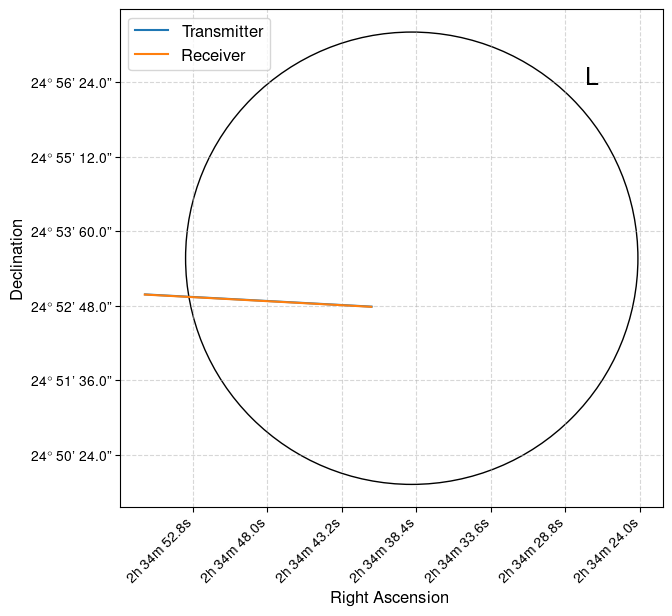

In [11]:
# plot the first hit
plot_probe_focal_lines(0)

In [12]:
# get gaia source ids that appear in observation list
common_ids = set(gaia_tbl["source_id"]).intersection(df["gaia_source_id"])

idx = []
for i in common_ids:
    idx.append(np.where(gaia_tbl["source_id"] == i)[0][0])

# get maximum proper motion
gaia_pmra = gaia_tbl[idx]["pmra"]
gaia_pmdec = gaia_tbl[idx]["pmdec"]
gaia_pm = np.sqrt(gaia_pmra**2.0 + gaia_pmdec**2.0)
pm_idx = np.argmax(gaia_pm)
gaia_maxpm_source_id = gaia_tbl["source_id"][idx[pm_idx]]

print("Largest proper motion: " + str(gaia_pm[pm_idx]))

Largest proper motion: 661.4666883026124 mas / yr


/var/folders/3c/fysw_z753d349yytn2sbytcc0000gn/T/ipykernel_36894/2008137449.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(map(format_ra_string, axs.get_xticks()), rotation=45, fontsize=10, ha="right")
/var/folders/3c/fysw_z753d349yytn2sbytcc0000gn/T/ipykernel_36894/2008137449.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(map(format_dec_string, axs.get_yticks()), fontsize=10)


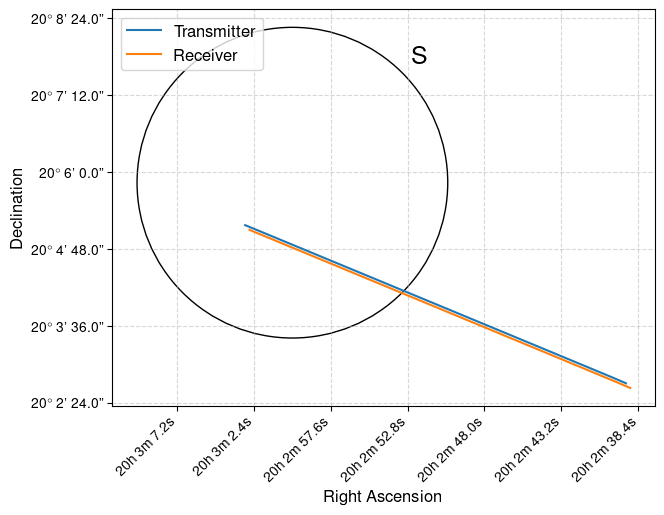

In [13]:
# get corresponding observation index
idx = np.where(df["gaia_source_id"].values == gaia_maxpm_source_id)[0][0]

# plot focal lines for star with largest proper motion
plot_probe_focal_lines(idx)

In [14]:
# get maximum drift rates
max_drift = np.zeros(len(df))

for i in range(len(df)):
    idx_trans = np.argmax(np.abs(df.loc[i, "maxdrift_trans"]))
    idx_rec = np.argmax(np.abs(df.loc[i, "maxdrift_rec"]))
    max_drift_trans = df.loc[i, "maxdrift_trans"][idx_trans]
    max_drift_rec = df.loc[i, "maxdrift_rec"][idx_rec]

    temp_drift = [max_drift_trans, max_drift_rec]
    
    idx = np.argmax(np.abs(temp_drift))
    max_drift[i] = temp_drift[idx]


In [15]:
# discriminate drift rates by observations bands
L_idx = df["obs_band"] == "L"
S_idx = df["obs_band"] == "S"
C_idx = df["obs_band"] == "C"
X_idx = df["obs_band"] == "X"

max_drift_L = max_drift[L_idx]
max_drift_S = max_drift[S_idx]
max_drift_C = max_drift[C_idx]
max_drift_X = max_drift[X_idx]

Text(0, 0.5, 'Probability Density')

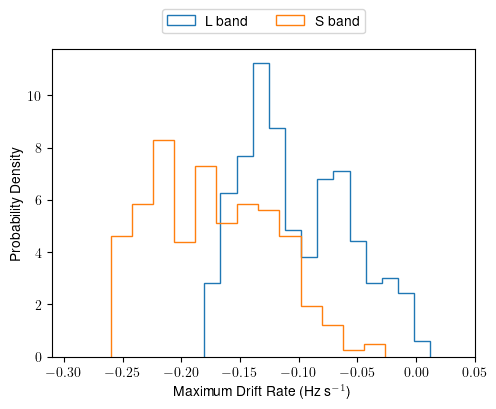

In [16]:
# plot disttributions of max drift rates
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)

ax1.hist(max_drift_L, histtype="step", color="tab:blue", bins="auto", label="L band", density=True)
ax1.hist(max_drift_S, histtype="step", color="tab:orange", bins="auto", label="S band", density=True)
# ax1.hist(max_drift_C, histtype="step", color="tab:green", bins="auto", label="C band", density=True)
# ax1.hist(max_drift_X, histtype="step", color="tab:brown", bins="auto", label="X band", density=True)

ax1.set_xlim(np.min(max_drift_S) - 0.05, 0.05)
ax1.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=4)
ax1.set_xlabel("Maximum Drift Rate (Hz s$^{-1}$)")
ax1.set_ylabel("Probability Density")

In [17]:
print(len(max_drift_L))
print(len(max_drift_S))
print(len(max_drift_C))
print(len(max_drift_X))

1080
684
0
0


In [18]:
print(np.median(max_drift_L))
print(np.median(max_drift_S))
print(np.median(max_drift_C))
print(np.median(max_drift_X))

-0.112706505
-0.18043715500000002
nan
nan


/usr/local/anaconda3/envs/seti/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/seti/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
print(df.url[25])

https://bldata.berkeley.edu/pipeline/AGBT16B_999_22/holding/spliced_blc0001020304050607_guppi_57641_34642_HIP24819_0007.gpuspec.0000.h5
